<a href="https://colab.research.google.com/github/priyanshum17/pressure/blob/main/FSR_data_analysis_Jul_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXPERIMENT: CALLIBRATION FOR SENSORS A,B,C,D**




You will upload one CSV file per sensor per weight (e.g., CAL_A_10g_trial1.csv, CAL_B_30g_trial1.csv, etc.).
Each file contains a column with ADC values from FSR1 only.
You'll provide a list mapping filenames to their corresponding weight (in grams).




Saving CAL_B_24.54g_trial1.csv to CAL_B_24.54g_trial1 (1).csv
Saving CAL_B_24.54g_trial2.csv to CAL_B_24.54g_trial2 (1).csv
Saving CAL_B_24.54g_trial3.csv to CAL_B_24.54g_trial3 (1).csv
Saving CAL_B_38.7g_trial1.csv to CAL_B_38.7g_trial1 (1).csv
Saving CAL_B_38.7g_trial2.csv to CAL_B_38.7g_trial2 (1).csv
Saving CAL_B_38.7g_trial3.csv to CAL_B_38.7g_trial3 (1).csv
Saving CAL_B_62.97g_trial1.csv to CAL_B_62.97g_trial1 (1).csv
Saving CAL_B_62.97g_trial2.csv to CAL_B_62.97g_trial2 (1).csv
Saving CAL_B_62.97g_trial3.csv to CAL_B_62.97g_trial3 (1).csv
Saving CAL_B_96.9g_trial1.csv to CAL_B_96.9g_trial1 (1).csv
Saving CAL_B_96.9g_trial2.csv to CAL_B_96.9g_trial2 (1).csv
Saving CAL_B_96.9g_trial3.csv to CAL_B_96.9g_trial3 (1).csv
Saving CAL_B_119.1g_trial1.csv to CAL_B_119.1g_trial1 (1).csv
Saving CAL_B_119.1g_trial2.csv to CAL_B_119.1g_trial2 (1).csv
Saving CAL_B_119.1g_trial3.csv to CAL_B_119.1g_trial3 (1).csv
Saving CAL_B_175.37g_trial1.csv to CAL_B_175.37g_trial1 (1).csv
Saving CAL_B_175.3

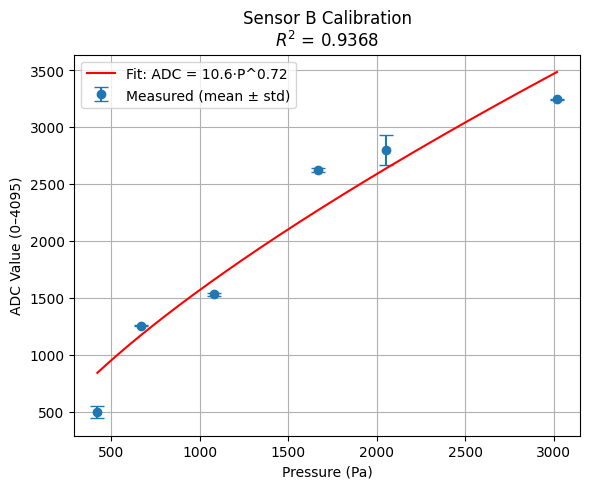

📐 Sensor D: Fit → ADC = 24.28 * P^0.61 | R² = 0.9039


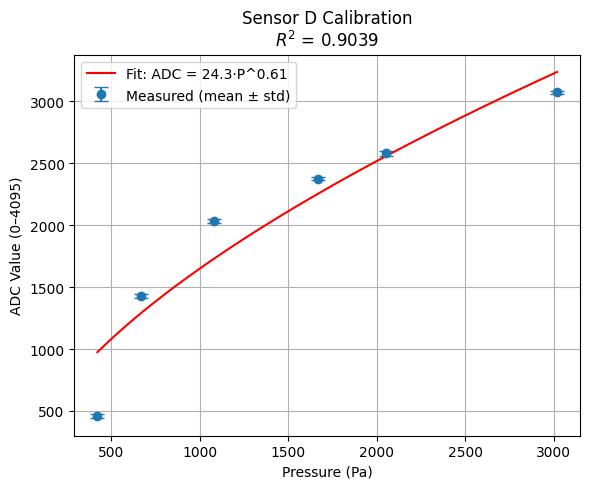

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.optimize import curve_fit
import re
from collections import defaultdict
import os

# Constants
R_FIXED = 10000
V_IN = 3.3
ADC_RES = 4095       # Teensy 16-bit = 65535, adjust as needed
AREA = 5.7e-4        # m² (FSR active area)
G = 9.81             # m/s²

# Upload CSVs
uploaded = files.upload()

# Clean filenames
renamed = {}
for fname in uploaded:
    clean_name = re.sub(r"\s+", "", fname)
    clean_name = re.sub(r"\(\d+\)", "", clean_name)
    if fname != clean_name:
        os.rename(fname, clean_name)
        renamed[fname] = clean_name
    else:
        renamed[fname] = fname
uploaded = {renamed[f]: uploaded[f] for f in renamed}

# Buffer for (sensor, pressure) → [adc readings]
trial_buffer = defaultdict(list)

for fname in uploaded:
    match = re.search(r"CAL_([A-Z])_(\d+\.?\d*)g_?trial(\d+)\.csv", fname)
    if not match:
        print(f"⚠️ Skipping unrecognized file: {fname}")
        continue

    sensor = match.group(1)
    mass_g = float(match.group(2))
    trial_num = int(match.group(3))

    mass_kg = mass_g / 1000
    force = mass_kg * G
    pressure = force / AREA  # Pascals

    try:
        df = pd.read_csv(fname, header=None)
        adc_values = []

        for line in df[0]:
            adc_match = re.search(r'ADC:\s*(\d+)', line)
            if adc_match:
                adc = int(adc_match.group(1))
                adc_values.append(adc)

        if len(adc_values) == 0:
            print(f"⚠️ No ADC values found in {fname}")
            continue

        mean_adc = np.mean(adc_values)
        std_adc = np.std(adc_values)

        print(f"📄 {fname} → Pressure = {pressure:.2f} Pa | Mean ADC = {mean_adc:.2f} | Std = {std_adc:.2f}")
        trial_buffer[(sensor, pressure)].append(adc_values)

    except Exception as e:
        print(f"⚠️ Error processing {fname}: {e}")

# Organize into sensor-wise data
sensor_data = defaultdict(list)

for (sensor, pressure), adc_lists in trial_buffer.items():
    all_vals = np.concatenate(adc_lists)
    mean_adc = np.mean(all_vals)
    std_adc = np.std(all_vals)
    sensor_data[sensor].append((pressure, mean_adc, std_adc))

# Power law model
def power_law(P, a, b):
    return a * np.power(P, b)

# Plotting
for sensor, datapoints in sensor_data.items():
    datapoints.sort()
    pressures, adc_means, adc_stds = zip(*datapoints)
    pressures = np.array(pressures)
    adc_means = np.array(adc_means)
    adc_stds = np.array(adc_stds)

    try:
        popt, _ = curve_fit(power_law, pressures, adc_means, maxfev=10000)
        a, b = popt
        predicted_adc = power_law(pressures, *popt)

        # R²
        ss_res = np.sum((adc_means - predicted_adc) ** 2)
        ss_tot = np.sum((adc_means - np.mean(adc_means)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        # Debug print
        print(f"📐 Sensor {sensor}: Fit → ADC = {a:.2f} * P^{b:.2f} | R² = {r_squared:.4f}")

        # Plot with error bars
        fit_x = np.linspace(min(pressures), max(pressures), 200)
        fit_y = power_law(fit_x, *popt)

        plt.figure(figsize=(6, 5))
        plt.errorbar(pressures, adc_means, yerr=adc_stds, fmt='o', capsize=5, label='Measured (mean ± std)')
        plt.plot(fit_x, fit_y, '-', color='red', label=f'Fit: ADC = {a:.1f}·P^{b:.2f}')
        plt.xlabel("Pressure (Pa)")
        plt.ylabel("ADC Value (0–4095)")
        plt.title(f"Sensor {sensor} Calibration\n$R^2$ = {r_squared:.4f}")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Fit failed for sensor {sensor}: {e}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import re
import os
from collections import defaultdict

# Paste your power-law fit coefficients for each sensor here
# Format: 'A': (a, b) where ADC = a * P^b  =>  P = (ADC/a)^(1/b)
sensor_fit_coeffs = {
    'A': (18.7, 0.56),   # example coefficients — replace with your values
    'B': (20.2, 0.53),
    'C': (16.4, 0.60)
}

# Constants
AREA = 5.7e-4  # m^2
G = 9.81       # m/s²

# Upload all trial files
uploaded = files.upload()

# Clean file names
renamed = {}
for fname in uploaded:
    clean_name = re.sub(r"\s+", "", fname)
    clean_name = re.sub(r"\(\d+\)", "", clean_name)
    if fname != clean_name:
        os.rename(fname, clean_name)
    renamed[fname] = clean_name

# Buffer to store results per (sensor, weight)
adc_results = defaultdict(lambda: {'with': [], 'without': []})
noise_levels = {}

# Parse files
for fname in renamed.values():
    match = re.search(r"CAL_([A-Z])_(\d+)g_(with|without)_lump_trial(\d+)\.csv", fname)
    if not match:
        print(f"⚠️ Skipping unrecognized file: {fname}")
        continue

    sensor, mass_g, condition, trial = match.groups()
    mass_g = int(mass_g)
    condition = 'with' if condition == 'with' else 'without'

    try:
        df = pd.read_csv(fname)
        adc_vals = df.select_dtypes(include=[np.number]).iloc[:, 0]
        adc_mean = adc_vals.mean()
        adc_results[(sensor, mass_g)][condition].append(adc_mean)

        # For noise level: record min and max only during no-lump
        if condition == 'without':
            key = (sensor, mass_g)
            if key not in noise_levels:
                noise_levels[key] = []
            noise_levels[key].extend(adc_vals.tolist())
    except Exception as e:
        print(f"❌ Error reading {fname}: {e}")

# Analyze
results = []

for (sensor, mass_g), data in adc_results.items():
    if len(data['with']) < 3 or len(data['without']) < 3:
        print(f"⚠️ Not enough trials for sensor {sensor}, {mass_g}g")
        continue

    a, b = sensor_fit_coeffs[sensor]

    adc_lump = np.mean(data['with'])
    adc_no_lump = np.mean(data['without'])

    pressure_lump = (adc_lump / a) ** (1 / b)
    pressure_no_lump = (adc_no_lump / a) ** (1 / b)

    delta_adc = adc_lump - adc_no_lump
    delta_p = pressure_lump - pressure_no_lump

    noise = max(noise_levels[(sensor, mass_g)]) - min(noise_levels[(sensor, mass_g)])
    detectable = "✅ Yes" if delta_adc > 3 * noise else ("⚠️ Borderline" if delta_adc > 1.5 * noise else "❌ No")

    results.append({
        "Sensor": sensor,
        "Weight (g)": mass_g,
        "ADC (no lump)": round(adc_no_lump, 2),
        "ADC (lump)": round(adc_lump, 2),
        "ΔADC": round(delta_adc, 2),
        "Noise": round(noise, 2),
        "Detectable?": detectable,
        "P (no lump) [Pa]": round(pressure_no_lump, 2),
        "P (lump) [Pa]": round(pressure_lump, 2),
        "ΔP [Pa]": round(delta_p, 2)
    })

# Display Results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Sensor", "Weight (g)"])
import ace_tools as tools; tools.display_dataframe_to_user(name="Lump Detection Results", dataframe=results_df)
